In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold,GridSearchCV
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 

In [258]:
data = pd.read_csv('creditcard.csv')
df = data.copy()

In [259]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


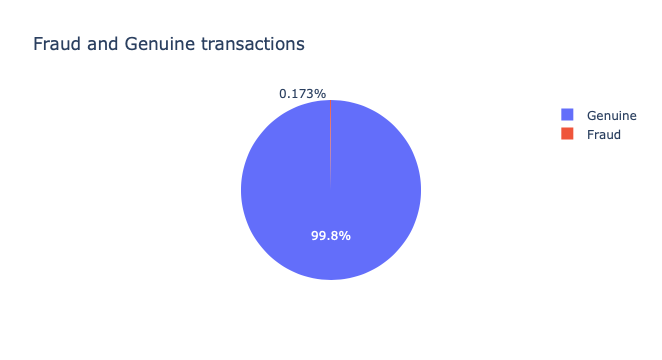

In [260]:
fig = px.pie(values = df['Class'].value_counts(),names = ['Genuine','Fraud'],title='Fraud and Genuine transactions')
fig.show()

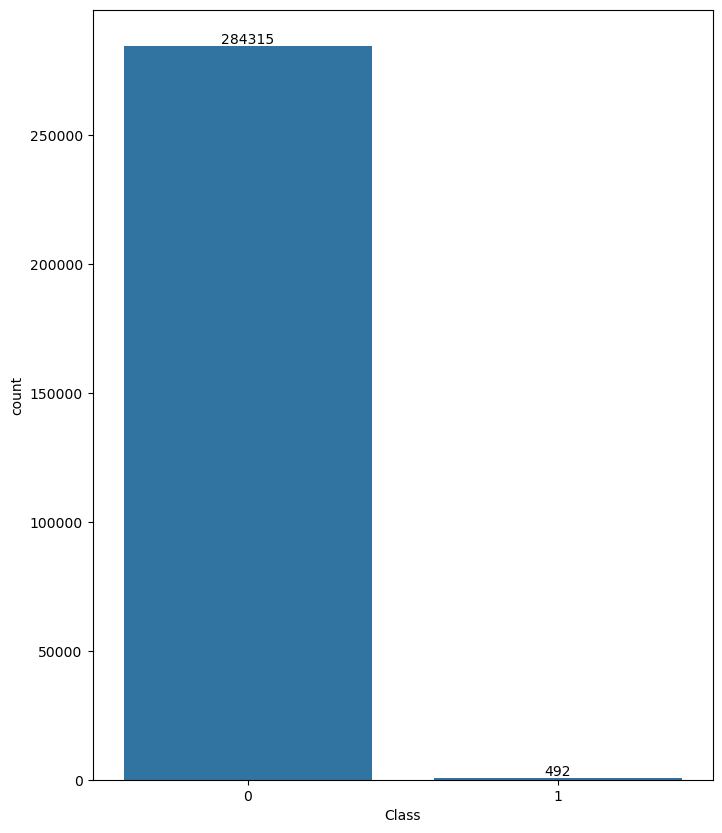

In [261]:
plt.figure(figsize=(8,10))
ax = sns.countplot(x =df['Class'],data=df)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

In [264]:
df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")
print("*" * 50)

Duplicated values dropped succesfully
**************************************************


In [267]:
num_cols = list(df.loc[:,'V1':'Amount'])
num_cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [270]:
num_plots = len(num_cols)
rows = (num_plots // 3) + (num_plots % 3 > 0) 

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows), dpi=300)
axes = axes.flatten() 

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"{col}")
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [271]:
from sklearn.ensemble import IsolationForest

normal_data = df[df["Class"] == 0] 
fraud_data = df[df["Class"] == 1]  

iso_forest = IsolationForest(contamination=0.01)

outlier_preds = iso_forest.fit_predict(normal_data)

normal_data_clean = normal_data[outlier_preds == 1]

df_clean = pd.concat([normal_data_clean, fraud_data], axis=0).reset_index(drop=True)

print(f"Original dataset size: {df.shape[0]}, After outlier removal: {df_clean.shape[0]}")
print(f'Total number of deleted outliers is : {df.shape[0]-df_clean.shape[0]}')

Original dataset size: 283726, After outlier removal: 280893
Total number of deleted outliers is : 2833


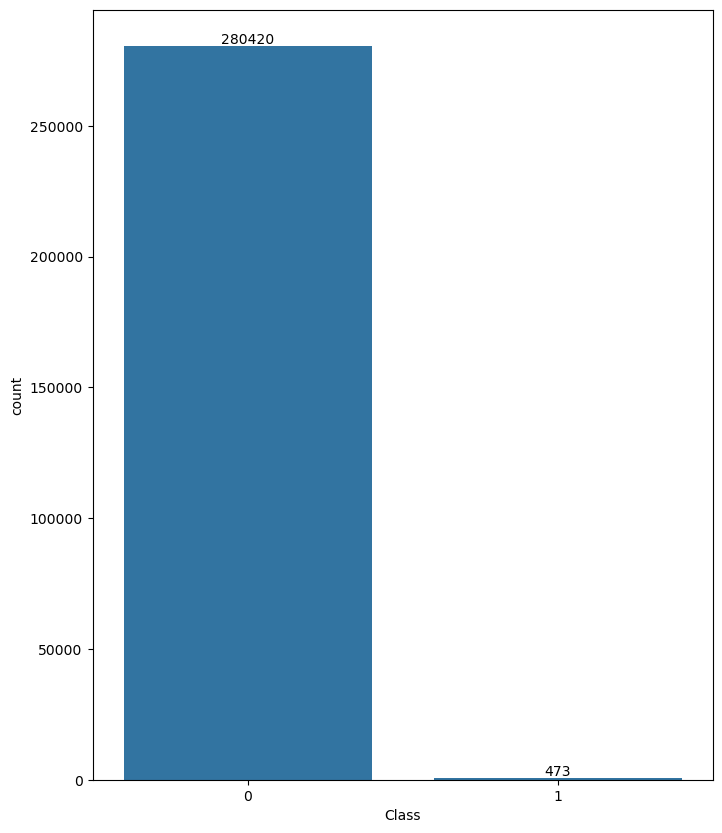

In [272]:
plt.figure(figsize=(8,10))
ax = sns.countplot(x =df_clean['Class'],data=df_clean)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

In [273]:
x = df_clean.drop('Class',axis=1)
y = df_clean['Class']

x_train,x_test,y_train,y_test = train_test_split(x,y,stratify = y ,test_size=0.2)

In [274]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [275]:
kf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
rf = RandomForestClassifier(n_estimators=100,max_depth = 12, random_state=13)

score = cross_val_score(rf, x_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.85333333 0.72368421 0.85526316 0.81578947 0.69333333]
Average Cross Validation Recall score: 0.788280701754386


In [276]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 12]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, n_jobs=-1,
                          scoring='recall').fit(x_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best Recall Score:", grid_rf.best_score_)

Best Parameters: {'max_depth': 12, 'n_estimators': 100}
Best Recall Score: 0.788280701754386


In [373]:
rf_norm = rf.fit(x_train,y_train)
y_pred_norm = rf_norm.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred_norm)
print(cm)

[[56082     2]
 [   22    73]]


## Oversampling SMOTE

In [284]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)  
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [286]:
print('Genuine:', y_resampled.value_counts()[0], '/', round(y_resampled.value_counts()[0]/len(y_resampled) * 100,2), '% of the dataset')
print('Frauds:', y_resampled.value_counts()[1], '/',round(y_resampled.value_counts()[1]/len(y_resampled) * 100,2), '% of the dataset')

Genuine: 224336 / 66.67 % of the dataset
Frauds: 112168 / 33.33 % of the dataset


In [290]:
score2 = cross_val_score(rf,x_resampled,y_resampled,scoring='recall',cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.97463558 0.97485959 0.97441384 0.97543907 0.97472474]
Average Cross Validation Recall score: 0.974814561472028


In [374]:
smote_rf = rf.fit(x_resampled, y_resampled)

y_pred = smote_rf.predict(x_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[56073    11]
 [   20    75]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56084
           1       0.87      0.79      0.83        95

    accuracy                           1.00     56179
   macro avg       0.94      0.89      0.91     56179
weighted avg       1.00      1.00      1.00     56179



In [375]:
from imblearn.combine import SMOTETomek
smtomek = SMOTETomek(sampling_strategy = 'auto')
x_smtomek, y_smtomek = smtomek.fit_resample(x_train,y_train)

smtomek_rf = rf.fit(x_smtomek,y_smtomek)
y_pred_smtomek = smtomek_rf.predict(x_test)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred_smtomek))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56084
           1       0.74      0.79      0.77        95

    accuracy                           1.00     56179
   macro avg       0.87      0.89      0.88     56179
weighted avg       1.00      1.00      1.00     56179



In [376]:
metrics_data = {
    "Recall": [
        recall_score(y_test, y_pred_norm),    # Without Sampling
        recall_score(y_test, y_pred),   # SMOTE
        recall_score(y_test, y_pred_smtomek), # SMOTETomek
        recall_score(y_test, y_pred_weight)
    ],
    "Precision": [
        precision_score(y_test, y_pred_norm),
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_smtomek),
        precision_score(y_test, y_pred_weight)
    ],
    "F1": [
        f1_score(y_test, y_pred_norm),
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_smtomek),
        f1_score(y_test, y_pred_weight)
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_norm),
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_smtomek),
        accuracy_score(y_test, y_pred_weight)
    ]
}

df_metrics = pd.DataFrame(metrics_data, index=['Without Sampling', 'SMOTE', 'SMOTETomek','SMOTE Weighted'])
print(df_metrics)

                    Recall  Precision        F1  Accuracy
Without Sampling  0.768421   0.973333  0.858824  0.999573
SMOTE             0.789474   0.872093  0.828729  0.999448
SMOTETomek        0.789474   0.742574  0.765306  0.999181
SMOTE Weighted    0.778947   0.948718  0.855491  0.999555


In [309]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")
rfb.fit(x_resampled, y_resampled)
y_pred_weight = rfb.predict(x_test)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56084
           1       0.87      0.79      0.83        95

    accuracy                           1.00     56179
   macro avg       0.94      0.89      0.91     56179
weighted avg       1.00      1.00      1.00     56179



In [384]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba_smote = smote_rf.predict_proba(x_test)[: , 1] 
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)

print("ROC-AUC Score:")
print(f"SMOTE: {roc_auc_smote:.4f}")

ROC-AUC Score:
SMOTE: 0.9820


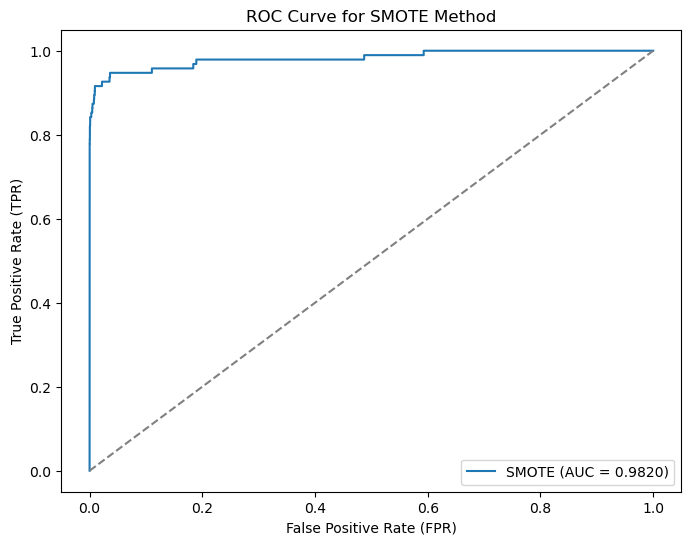

In [388]:
plt.figure(figsize=(8,6))
plt.plot(fpr_smote, tpr_smote, label=f"SMOTE (AUC = {roc_auc_smote:.4f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for SMOTE Method")
plt.legend()
plt.show()


In [390]:
import joblib

joblib.dump(smote_rf, 'random_forest_smote_model.pkl')

['random_forest_smote_model.pkl']